# First Assignment: Course of Multiagent Systems for smart machining.

Student: Daniele Trisotto

University of Trento 

## Assignment: 
Calculate the minimum and maximum Specific Cutting Pressure for each diameter, in both cases : Constant Cutting Speed and Constant Spindle Speed. 

For that, you should identify the minimum and maximum power (Pc) used in each diameter during machining, calculate the cutting force (Fc) in each case and finally the specific pressure, also called, specific cutting force (Kc).

You can present the values in a table or in a colonne graphic, for example.

## Importing Data

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import matplotlib.ticker as ticker


# File data CSV
filedataC150 = 'ANNACHPTVC150.csv'                        #cut
filedataNC150 = 'ANNACHPTVC150VIDE.csv'                   #nocut
filedataC1200 = 'ANNACHPT1200RPM.csv'                     #cut
filedataNC1200 = 'ANNACHPT1200RPMVIDE.csv'                #nocut

# Reading csv
dfC150 = pd.read_csv(filedataC150, skiprows=10)
dfNC150 = pd.read_csv(filedataNC150, skiprows=10)
dfC1200 = pd.read_csv(filedataC1200, skiprows=10)
dfNC1200 = pd.read_csv(filedataNC1200, skiprows=10)

# # Columns names / Same for all data
dfC150.columns = [
    'time',
    'power',
    'prog_pos_z',
    'prog_pos_x',
    'meas_pos_z',
    'meas_pos_x',
    'spindle1' # only the first data does not have the spindle 2 data
]
dfNC150.columns = [
    'time',
    'power',
    'prog_pos_z',
    'prog_pos_x',
    'meas_pos_z',
    'meas_pos_x',
    'spindle1',
    'spindle2'
]
dfC1200.columns = [
    'time',
    'power',
    'prog_pos_z',
    'prog_pos_x',
    'meas_pos_z',
    'meas_pos_x',
    'spindle1',
    'spindle2'
]
dfNC1200.columns = [
    'time',
    'power',
    'prog_pos_z',
    'prog_pos_x',
    'meas_pos_z',
    'meas_pos_x',
    'spindle1',
    'spindle2'
]

# estrae tutte le colonne fatta eccezione di "time"
cols_to_convert = dfC150.columns.difference(['time'])  # or specify manually

# # Conversion in numeric format 
# for col in df.columns:
for df in [dfC150, dfNC150, dfC1200, dfNC1200]:
    for col in cols_to_convert:
        df[col] = pd.to_numeric(df[col], errors='coerce')
        
        


dfC150 = dfC150.dropna()
dfNC150 = dfNC150.dropna()
dfC1200 = dfC1200.dropna()
dfNC1200 = dfNC1200.dropna()

#### Programming Parameters:

In [2]:
ap=1  #mm
f=0.2 #mm/rev
Vc150=150 #m/min

## Specific Cutting Pressure Calculation

### Calculating Cutting Power

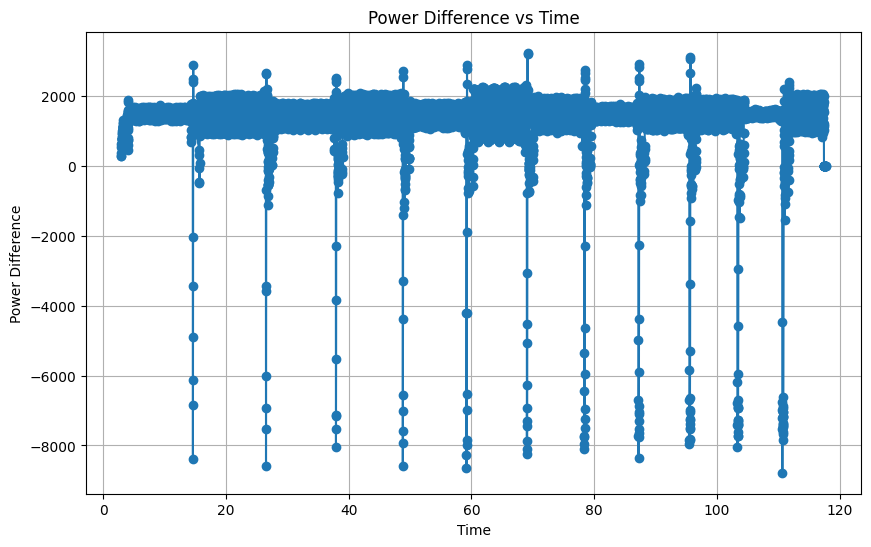

In [6]:
# find minimum difference between two dataframes
n150 = min(len(dfC150), len(dfNC150))
n1200 = min(len(dfC1200), len(dfNC1200))

# Initializing a column of power difference
dfC150['power_diff']=0.0
dfC1200['power_diff']=0.0

# Calculating the power difference between cutting and non cutting
dfC150.loc[dfC150.index[:n150], 'power_diff'] = dfC150['power'].iloc[:n150].values - dfNC150['power'].iloc[:n150].values
dfC1200.loc[dfC1200.index[:n1200], 'power_diff'] = dfC1200['power'].iloc[:n1200].values - dfNC1200['power'].iloc[:n1200].values

#Filtering only machining positions less than 47 and exact machining X positions and Z positions between 0 and -40
dfC150_filtered = dfC150[(dfC150['prog_pos_x'] <= 47)&(np.isclose(dfC150['prog_pos_x'] % 1, 0.0))&(dfC150['prog_pos_z']<=0.0)&(dfC150['prog_pos_z']>=-40.0)].copy() 
dfC1200_filtered = dfC1200[(dfC1200['prog_pos_x'] <= 47)&(np.isclose(dfC1200['prog_pos_x'] % 1, 0.0))&(dfC1200['prog_pos_z']<=0.0)&(dfC1200['prog_pos_z']>=-40.0)].copy()

plt.figure(figsize=(10, 6))
plt.plot(dfC150_filtered['time'], dfC150_filtered['power_diff'], marker='o', linestyle='-')
plt.xlabel('Time')
plt.ylabel('Power Difference')
plt.title('Power Difference vs Time')
plt.grid(True)
plt.show()

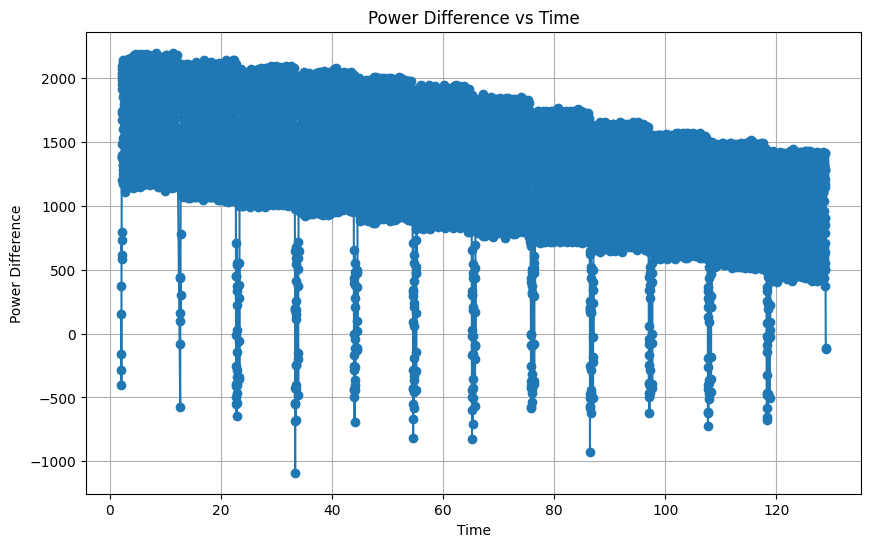

In [7]:
plt.figure(figsize=(10, 6))
plt.plot(dfC1200_filtered['time'], dfC1200_filtered['power_diff'], marker='o', linestyle='-')
plt.xlabel('Time')
plt.ylabel('Power Difference')
plt.title('Power Difference vs Time')
plt.grid(True)
plt.show()

From the previous graphs we can see that there are some outliers, in the next section outliers are removed

### Outliers Removing from Vc=150

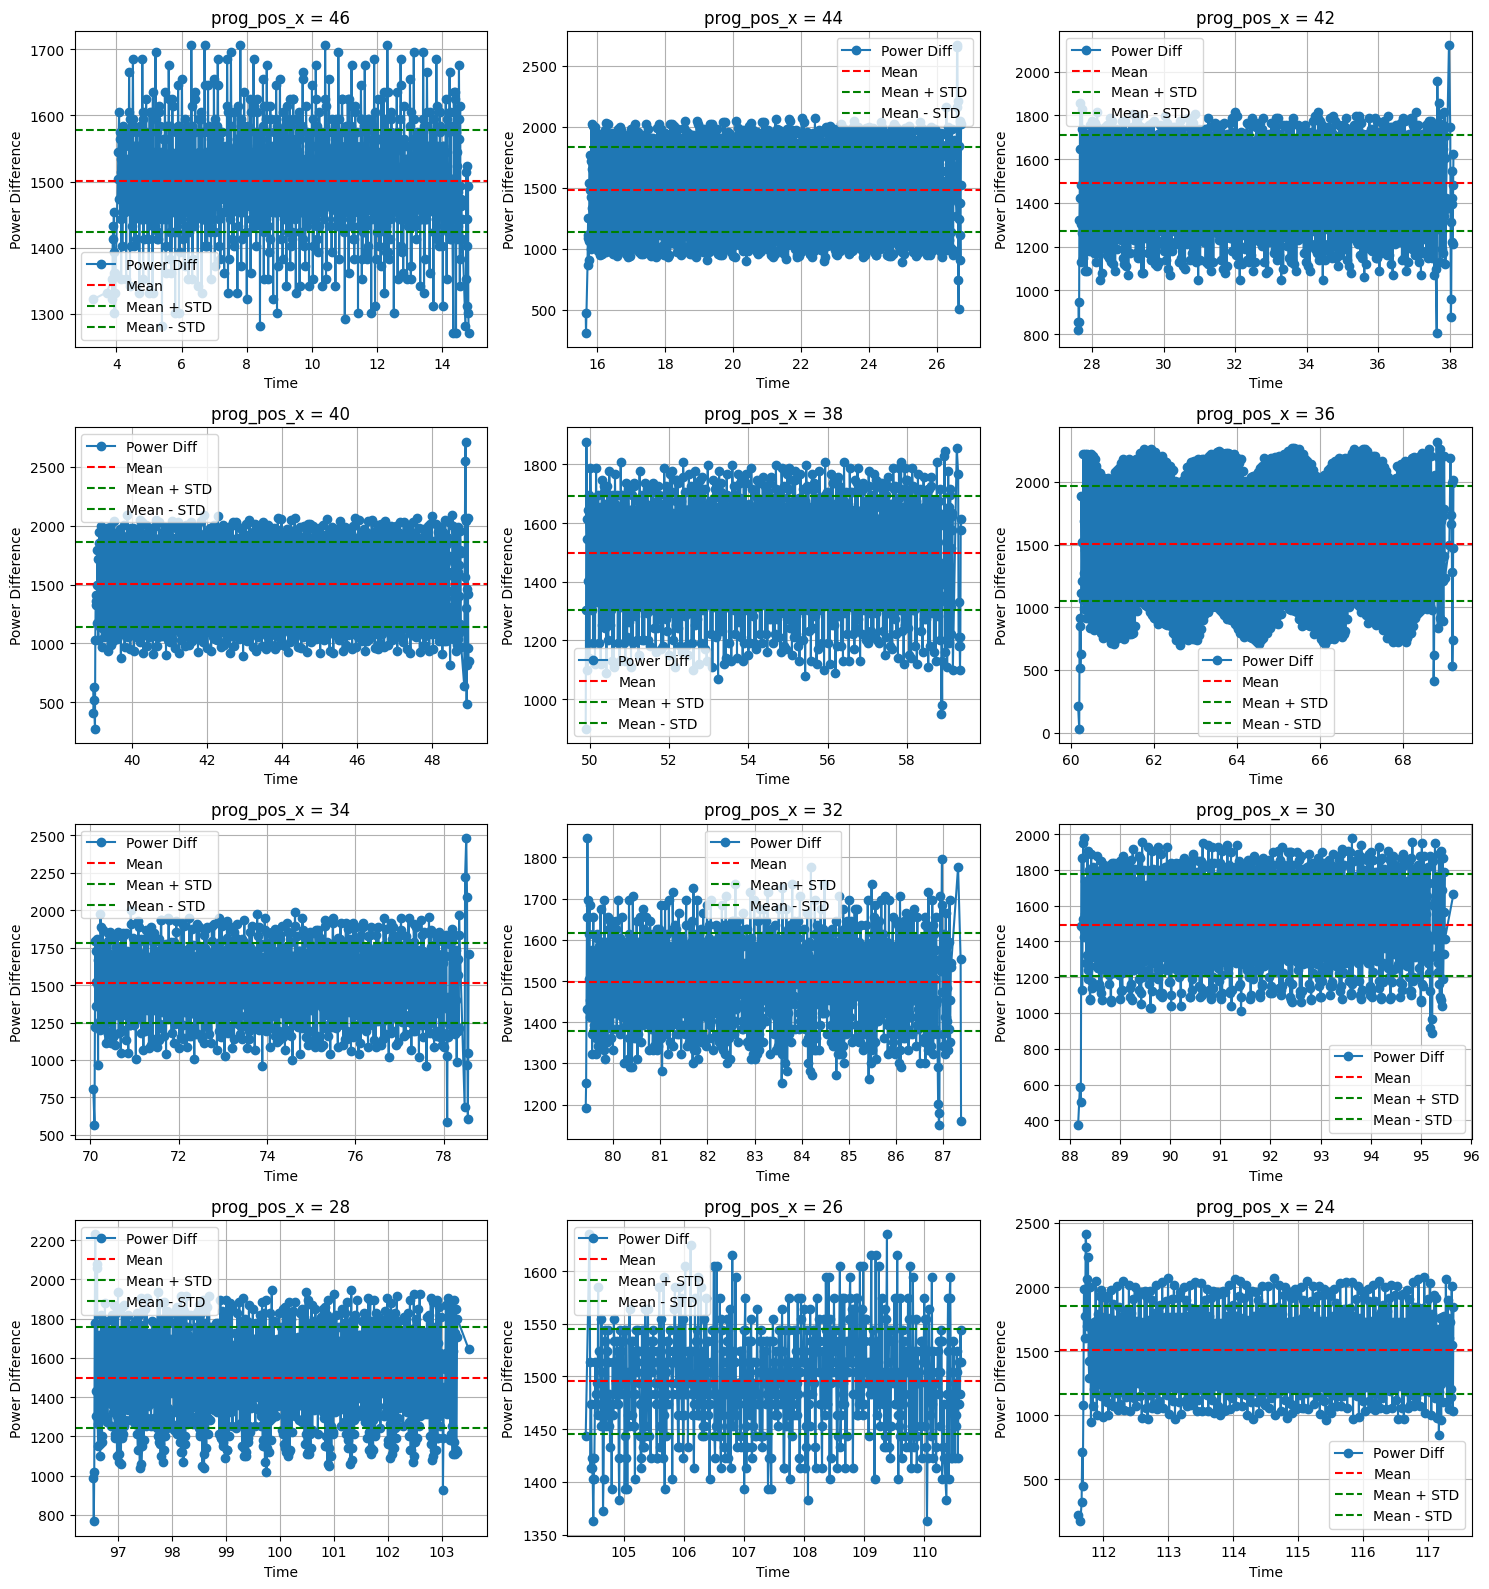

In [8]:
from sklearn.cluster import DBSCAN
import numpy as np
import matplotlib.pyplot as plt
from collections import Counter
import pandas as pd

# Lista dei diametri
prog_values = list(range(46, 23, -2))

# Imposta subplot
n_cols = 3
n_rows = (len(prog_values) + n_cols - 1) // n_cols
fig, axes = plt.subplots(n_rows, n_cols, figsize=(15, n_rows*4))
axes = axes.flatten()

# Nuovo DataFrame per salvare tutti i dati puliti
df_150 = pd.DataFrame()

for i, prog in enumerate(prog_values):
    df_prog = dfC150_filtered[dfC150_filtered['prog_pos_x'] == prog]
    if df_prog.empty:
        continue
    
    # DBSCAN su tempo
    time_values = df_prog['time'].values.reshape(-1, 1)
    db = DBSCAN(eps=2.0, min_samples=5)
    labels = db.fit_predict(time_values)
    
    label_counts = Counter(labels)
    if -1 in label_counts:
        del label_counts[-1]
    if not label_counts:
        continue
    
    main_cluster = label_counts.most_common(1)[0][0]
    df_cluster = df_prog[labels == main_cluster]
    
    # deviazione robusta e filtro amplitude outliers
    median_val = df_cluster['power_diff'].median()
    mad_val = np.median(np.abs(df_cluster['power_diff'] - median_val))
    robust_std = 1.4826 * mad_val
    df_cluster_clean = df_cluster[np.abs(df_cluster['power_diff'] - median_val) <= 3 * robust_std]
    
    # salva i dati puliti nel DataFrame complessivo
    df_150 = pd.concat([df_150, df_cluster_clean], ignore_index=True)
    
    # ricalcolo media e std per plot
    mean_val = df_cluster_clean['power_diff'].mean()
    std_val = df_cluster_clean['power_diff'].std()
    
    # plot
    ax = axes[i]
    ax.plot(df_cluster_clean['time'], df_cluster_clean['power_diff'], marker='o', linestyle='-', label='Power Diff')
    ax.axhline(mean_val, color='red', linestyle='--', label='Mean')
    ax.axhline(mean_val + std_val, color='green', linestyle='--', label='Mean + STD')
    ax.axhline(mean_val - std_val, color='green', linestyle='--', label='Mean - STD')
    
    ax.set_title(f'prog_pos_x = {prog}')
    ax.set_xlabel('Time')
    ax.set_ylabel('Power Difference')
    ax.grid(True)
    ax.legend()

# rimuove eventuali subplot vuoti
for j in range(i+1, len(axes)):
    fig.delaxes(axes[j])

plt.tight_layout()
plt.show()

### Outliers Removing from N=1200

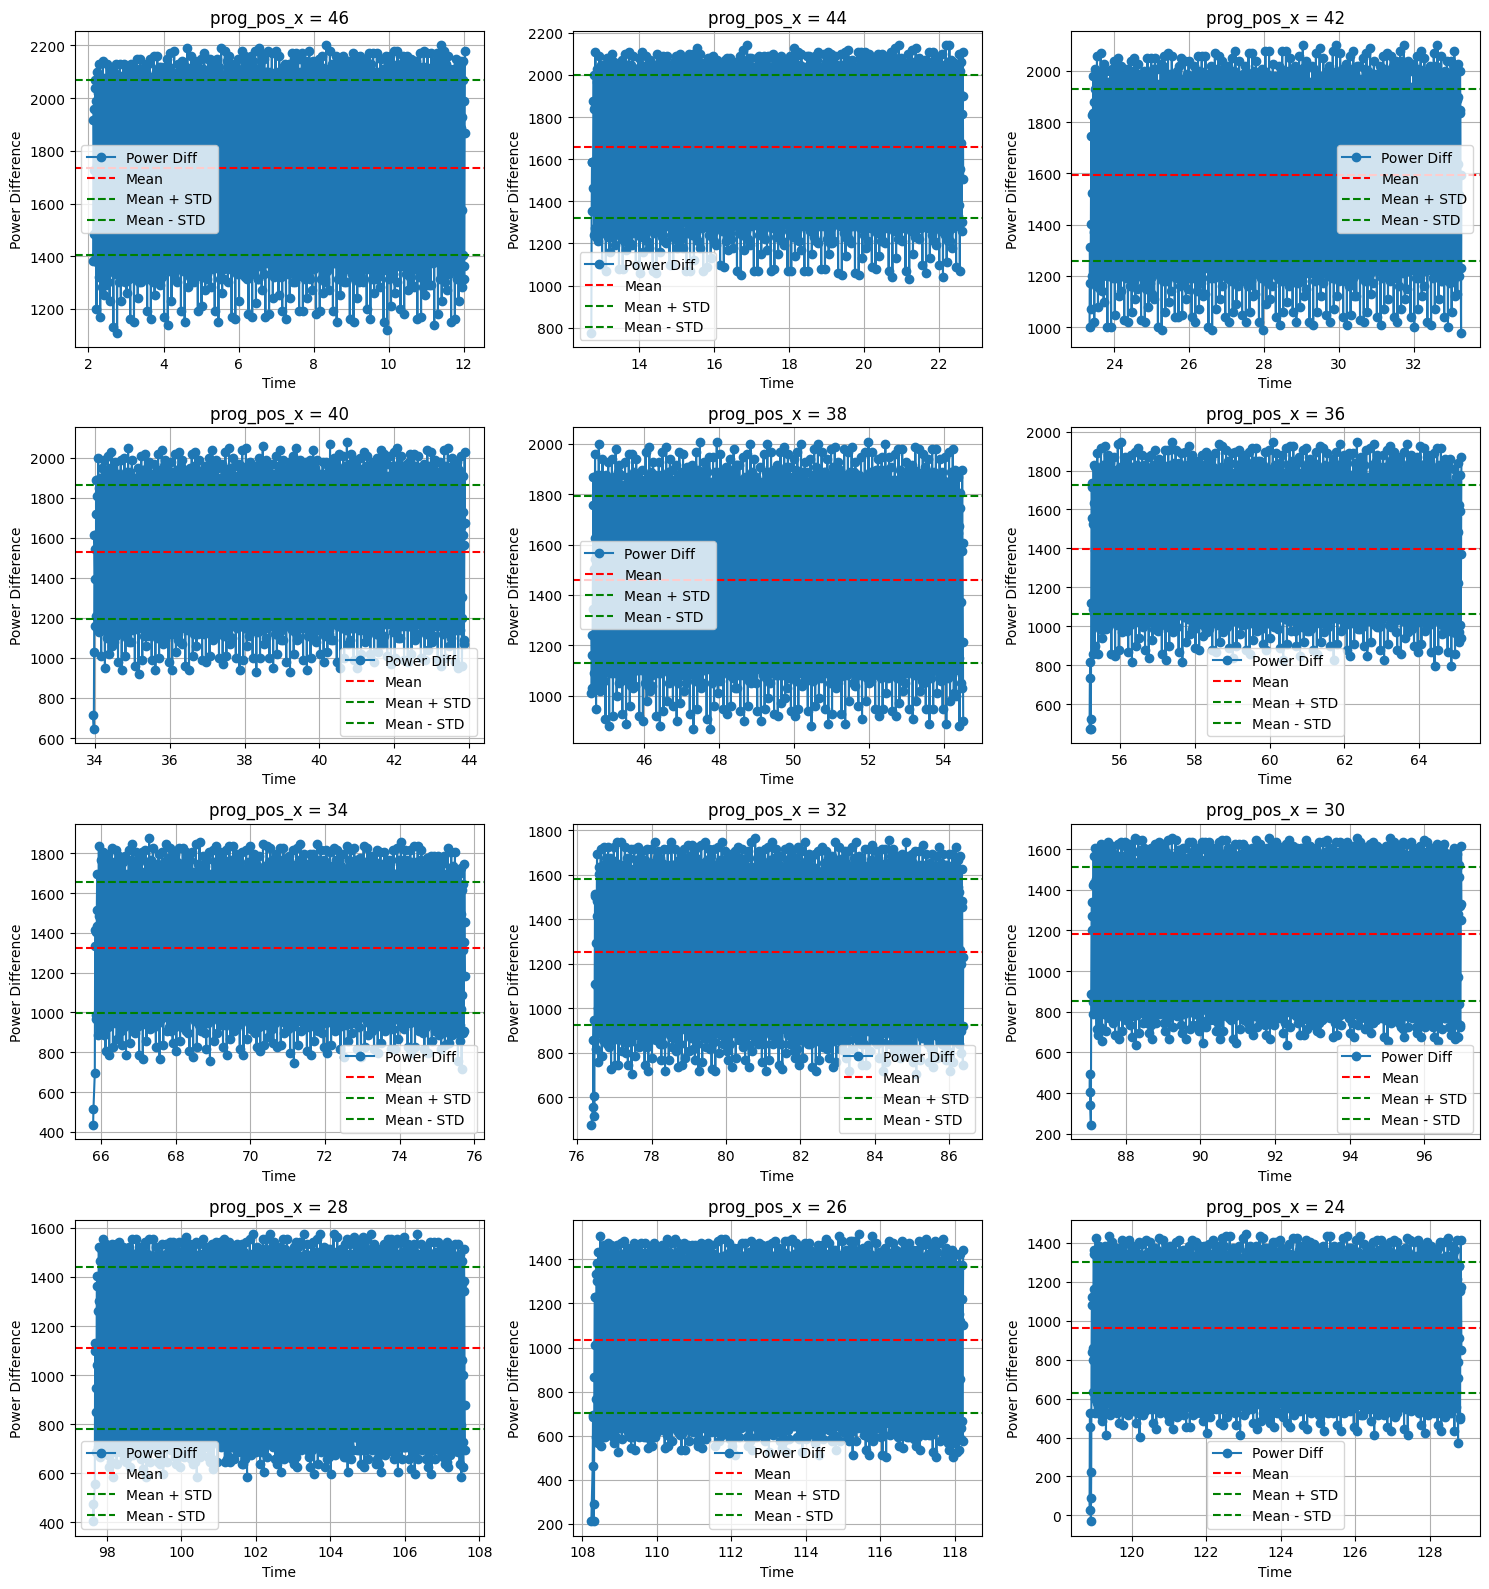

In [10]:
from sklearn.cluster import DBSCAN
import numpy as np
import matplotlib.pyplot as plt
from collections import Counter
import pandas as pd

# Lista dei diametri
prog_values = list(range(46, 23, -2))

# Imposta subplot
n_cols = 3
n_rows = (len(prog_values) + n_cols - 1) // n_cols
fig, axes = plt.subplots(n_rows, n_cols, figsize=(15, n_rows*4))
axes = axes.flatten()

# Nuovo DataFrame per salvare tutti i dati puliti
df_1200 = pd.DataFrame()

for i, prog in enumerate(prog_values):
    df_prog = dfC1200_filtered[dfC1200_filtered['prog_pos_x'] == prog]
    if df_prog.empty:
        continue
    
    # DBSCAN su tempo
    time_values = df_prog['time'].values.reshape(-1, 1)
    db = DBSCAN(eps=2.0, min_samples=5)
    labels = db.fit_predict(time_values)
    
    label_counts = Counter(labels)
    if -1 in label_counts:
        del label_counts[-1]
    if not label_counts:
        continue
    
    main_cluster = label_counts.most_common(1)[0][0]
    df_cluster = df_prog[labels == main_cluster]
    
    # deviazione robusta e filtro amplitude outliers
    median_val = df_cluster['power_diff'].median()
    mad_val = np.median(np.abs(df_cluster['power_diff'] - median_val))
    robust_std = 1.4826 * mad_val
    df_cluster_clean = df_cluster[np.abs(df_cluster['power_diff'] - median_val) <= 2 * robust_std]
    
    # salva i dati puliti nel DataFrame complessivo
    df_1200 = pd.concat([df_1200, df_cluster_clean], ignore_index=True)
    
    # ricalcolo media e std per plot
    mean_val = df_cluster_clean['power_diff'].mean()
    std_val = df_cluster_clean['power_diff'].std()
    
    # plot
    ax = axes[i]
    ax.plot(df_cluster_clean['time'], df_cluster_clean['power_diff'], marker='o', linestyle='-', label='Power Diff')
    ax.axhline(mean_val, color='red', linestyle='--', label='Mean')
    ax.axhline(mean_val + std_val, color='green', linestyle='--', label='Mean + STD')
    ax.axhline(mean_val - std_val, color='green', linestyle='--', label='Mean - STD')
    
    ax.set_title(f'prog_pos_x = {prog}')
    ax.set_xlabel('Time')
    ax.set_ylabel('Power Difference')
    ax.grid(True)
    ax.legend()

# rimuove eventuali subplot vuoti
for j in range(i+1, len(axes)):
    fig.delaxes(axes[j])

plt.tight_layout()
plt.show()

### KC Calculation for Vc=150

In [ ]:
# adding a column for Kc and calculating it 
df_150['Kc']=df_150['power_diff']*60/(Vc150*ap*f)

# 4) calculating Kc max and min
df_Kc_summary = (
    df_150
    .groupby('prog_pos_x')['Kc']
    .agg(['min', 'max', 'mean']) # aggregate: calculates statistical functions
    .reset_index() # comes back to normal columns after a groupbyy
    .rename(columns={'min': 'Kc_min', 'max': 'Kc_max', 'mean' :'Kc_mean'})
)

print(df_Kc_summary.iloc[::-1])

    prog_pos_x       Kc_min       Kc_max      Kc_mean
11        46.0  2543.401916  3411.388284  3002.742050
10        44.0   625.757614  5329.032585  2965.810678
9         42.0  1614.858359  4239.003193  2978.969377
8         40.0   545.014696  5429.961232  3002.782396
7         38.0  1796.529924  3754.545685  2993.466046
6         36.0    60.557188  4642.717782  3012.648763
5         34.0  1130.400851  4965.689454  3023.922336
4         32.0  2301.173162  3693.988496  2995.958970
3         30.0   746.871991  3956.402980  2985.671000
2         28.0  1534.115441  4461.046217  2999.497535
1         26.0  2725.073481  3270.088177  2990.548192
0         24.0   343.157401  4824.389348  3013.256310


### Kc Calculation for N=1200

In [11]:
# Assumendo che N sia costante a 1200 giri/min
N = 1200  # giri/min

# Calcola Vc per ogni riga in base al diametro (prog_pos_x)
df_1200['Vc_dia'] = np.pi * df_1200['prog_pos_x'] * N / 1000  # m/min

# Calcola Kc usando la nuova colonna Vc_dia
df_1200['Kc'] = df_1200['power_diff'] * 60 / (df_1200['Vc_dia'] * ap * f)

# Aggrega i valori di Kc per diametro
df_Kc_summary = (
    df_1200
    .groupby('prog_pos_x')['Kc']
    .agg(['min', 'max', 'mean'])
    .reset_index()
    .rename(columns={'min': 'Kc_min', 'max': 'Kc_max', 'mean':'Kc_mean'})
)

# Stampa capovolto
print(df_Kc_summary.iloc[::-1])

    prog_pos_x       Kc_min       Kc_max      Kc_mean
11        46.0  1920.611136  3806.302070  3003.866238
10        44.0  1405.538150  3869.793347  3001.153311
9         42.0  1854.927898  3977.577349  3019.109963
8         40.0  1285.063451  4136.297984  3037.979401
7         38.0  1817.688434  4206.046493  3058.695762
6         36.0  1048.576080  4305.854967  3083.271970
5         34.0  1015.767066  4393.783124  3104.178857
4         32.0  1179.648090  4392.306718  3118.157999
3         30.0   642.531726  4390.633458  3135.244293
2         28.0  1147.378081  4474.774518  3156.170728
1         26.0   648.709915  4633.642252  3170.699353
0         24.0  -100.395582  4785.522748  3197.554067
